In [32]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [33]:
# load dependencies
import sys
import pickle
import os
import shutil
import json
import pandas as pd
import numpy as np
import rdkit.Chem as Chem
from numpy.random import default_rng
import torch
from ast import literal_eval
from torch import nn, optim
from rdkit import Chem
from rdkit.Chem import AllChem
from tdc import Oracle
import subprocess


import matplotlib.pyplot as plt

In [34]:
print(os.getcwd())

/home/springnuance/reinvent-hitl/Base-Code-Binh


In [35]:
from training_Bradley_Terry_model.bradley_terry import BradleyTerryModel
from training_Rank_ListNet_model.rank_listnet import RankListNetModel
from training_Score_Regression_model.score_regression import ScoreRegressionModel
from scripts.helper import load_drd2_dataset, write_REINVENT_config, change_config_json, \
                    read_scaffold_result, load_feedback_model, smiles_human_score, \
                    compute_fingerprints, retrain_feedback_model,\
                    create_drd2_dataset, combine_drd2_dataset, save_drd2_dataset
                        
from sklearn.metrics import roc_curve, auc, precision_recall_fscore_support, matthews_corrcoef

### Loading analytics results

In [36]:
model_names = ["score_regression", "bradley_terry", "rank_listnet"]

models = {
    "score_regression": {},
    "bradley_terry": {},
    "rank_listnet": {}
}
for i, model_name in enumerate(model_names):
    for acquisition in ["random", "uncertainty", "greedy"]:
        for sigma_noise in [0.0, 0.1]:
            models[model_name][f"acq_{acquisition}_noise_{sigma_noise}"] = {}
            for props in ["smiles_list", "metrics", "drd2_proba", "novelty_score", "sa_score", "qed_score",\
                          "logP", "mol_weight", "h_donors", "h_acceptors",\
                            "tpsa", "rotatable_bonds", "num_rings"]:
                
                result = np.load(f"results_{model_name}_n_steps_100/acq_{acquisition}_noise_{sigma_noise}_{props}.npy", allow_pickle=True).tolist()
                #print(result)                
                models[model_name][f"acq_{acquisition}_noise_{sigma_noise}"][props] = result
                    
                

### Filter functions

In [42]:
from rdkit.Chem import Descriptors
from rdkit.Chem import Crippen
from rdkit.Chem import rdMolDescriptors
from rdkit.Chem import QED
from rdkit.Chem import DataStructs
from rdkit.Chem import RDConfig
import os
import sys
sys.path.append(os.path.join(RDConfig.RDContribDir, 'SA_Score'))
# now you can import sascore!
import sascorer

def props_filter(props_dict, threshold_dict):
    smiles_list = props_dict["smiles_list"]
    drd2_proba = props_dict["drd2_proba"]
    novelty_score = props_dict["novelty_score"]
    sa_score = props_dict["sa_score"]
    qed_score = props_dict["qed_score"]
    logP = props_dict["logP"]
    mol_weight = props_dict["mol_weight"]
    h_donors = props_dict["h_donors"]
    h_acceptors = props_dict["h_acceptors"]
    tpsa = props_dict["tpsa"]
    rotatable_bonds = props_dict["rotatable_bonds"]
    num_rings = props_dict["num_rings"]

    drd2_proba_threshold = threshold_dict.get("drd2_proba", 0.75) # Average drd2 prob predicted by Oracle for molecules that actually have drd2
    novelty_score_threshold = threshold_dict.get("novelty_score", 0.5) #  common threshold for the novelty score is around 0.7, meaning that a molecule should have a Tanimoto similarity of less than 0.5 to any molecule in the reference set.
    sa_score_threshold = threshold_dict.get("sa_score", 3.0) # Range from 1 to 10. A common threshold for acceptability is an SA score of 6 or lower.
    qed_score_threshold = threshold_dict.get("qed_score", 0.5) # Range from 0 to 1. A common threshold for acceptability is a QED score of 0.5 or higher.
    logP_threshold = threshold_dict.get("logP", 5.0) # Lipinski's rule of five, less than 5
    mol_weight_threshold = threshold_dict.get("mol_weight", 500.0) # Lipinski's rule of five, less than 500
    h_donors_threshold = threshold_dict.get("h_donors", 5.0) # Lipinski's rule of five, less than 5
    h_acceptors_threshold = threshold_dict.get("h_acceptors", 10.0) # Lipinski's rule of five, less than 10
    tpsa_threshold = threshold_dict.get("tpsa", 140.0) # Veber's rule, less than 140
    rotatable_bonds_threshold = threshold_dict.get("rotatable_bonds", 10.0) # Veber's rule, less than 10
    num_rings_threshold = threshold_dict.get("num_rings", 7) # Muegge's rule, less than 7

    props_dict_filtered = {}
    percentage_dict = {}
    means_dict = {}

    # Strategy: we need to find the indices that satisfy each condition, and then take the intersection of all of them

    # drd2_proba
    drd2_proba_indices = np.where(drd2_proba > drd2_proba_threshold)[0]
    satisfied_drd2_proba = len(drd2_proba_indices) / len(drd2_proba)
    novelty_score_indices = np.where(novelty_score > novelty_score_threshold)[0]
    satisfied_novelty_score = len(novelty_score_indices) / len(novelty_score)
    sa_score_indices = np.where(sa_score < sa_score_threshold)[0]
    satisfied_sa_score = len(sa_score_indices) / len(sa_score)
    qed_score_indices = np.where(qed_score > qed_score_threshold)[0]
    satisfied_qed_score = len(qed_score_indices) / len(qed_score)
    logP_indices = np.where(logP < logP_threshold)[0]
    satisfied_logP = len(logP_indices) / len(logP)
    mol_weight_indices = np.where(mol_weight < mol_weight_threshold)[0]
    satisfied_mol_weight = len(mol_weight_indices) / len(mol_weight)
    h_donors_indices = np.where(h_donors < h_donors_threshold)[0]
    satisfied_h_donors = len(h_donors_indices) / len(h_donors)
    h_acceptors_indices = np.where(h_acceptors < h_acceptors_threshold)[0]
    satisfied_h_acceptors = len(h_acceptors_indices) / len(h_acceptors)
    tpsa_indices = np.where(tpsa < tpsa_threshold)[0]
    satisfied_tpsa = len(tpsa_indices) / len(tpsa)
    rotatable_bonds_indices = np.where(rotatable_bonds < rotatable_bonds_threshold)[0]
    satisfied_rotatable_bonds = len(rotatable_bonds_indices) / len(rotatable_bonds)
    num_rings_indices = np.where(num_rings < num_rings_threshold)[0]
    satisfied_num_rings = len(num_rings_indices) / len(num_rings)

    # Finding the intersection of all index arrays
    common_indices = drd2_proba_indices
    for indices in [
        novelty_score_indices,
        sa_score_indices,
        qed_score_indices,
        logP_indices,
        mol_weight_indices,
        h_donors_indices,
        h_acceptors_indices,
        tpsa_indices,
        rotatable_bonds_indices,
        num_rings_indices
    ]:
        common_indices = np.intersect1d(common_indices, indices)

    props_dict_filtered["smiles_list"] = smiles_list[common_indices]
    props_dict_filtered["drd2_proba"] = drd2_proba[common_indices]
    props_dict_filtered["novelty_score"] = novelty_score[common_indices]
    props_dict_filtered["sa_score"] = sa_score[common_indices]
    props_dict_filtered["qed_score"] = qed_score[common_indices]
    props_dict_filtered["logP"] = logP[common_indices]
    props_dict_filtered["mol_weight"] = mol_weight[common_indices]
    props_dict_filtered["h_donors"] = h_donors[common_indices]
    props_dict_filtered["h_acceptors"] = h_acceptors[common_indices]
    props_dict_filtered["tpsa"] = tpsa[common_indices]
    props_dict_filtered["rotatable_bonds"] = rotatable_bonds[common_indices]
    props_dict_filtered["num_rings"] = num_rings[common_indices]

    percentage_dict["smiles_list"] = len(common_indices) / len(smiles_list)
    percentage_dict["drd2_proba"] = satisfied_drd2_proba
    percentage_dict["novelty_score"] = satisfied_novelty_score
    percentage_dict["sa_score"] = satisfied_sa_score
    percentage_dict["qed_score"] = satisfied_qed_score
    percentage_dict["logP"] = satisfied_logP
    percentage_dict["mol_weight"] = satisfied_mol_weight
    percentage_dict["h_donors"] = satisfied_h_donors
    percentage_dict["h_acceptors"] = satisfied_h_acceptors
    percentage_dict["tpsa"] = satisfied_tpsa
    percentage_dict["rotatable_bonds"] = satisfied_rotatable_bonds
    percentage_dict["num_rings"] = satisfied_num_rings

    means_dict["drd2_proba"] = np.mean(drd2_proba[common_indices])
    means_dict["novelty_score"] = np.mean(novelty_score[common_indices])
    means_dict["sa_score"] = np.mean(sa_score[common_indices])
    means_dict["qed_score"] = np.mean(qed_score[common_indices])
    means_dict["logP"] = np.mean(logP[common_indices])
    means_dict["mol_weight"] = np.mean(mol_weight[common_indices])
    means_dict["h_donors"] = np.mean(h_donors[common_indices])
    means_dict["h_acceptors"] = np.mean(h_acceptors[common_indices])
    means_dict["tpsa"] = np.mean(tpsa[common_indices])
    means_dict["rotatable_bonds"] = np.mean(rotatable_bonds[common_indices])
    means_dict["num_rings"] = np.mean(num_rings[common_indices])

    return props_dict_filtered, percentage_dict, means_dict




In [43]:
import copy

model_names = ["score_regression", "bradley_terry", "rank_listnet"]
props = ["smiles_list", "drd2_proba", "novelty_score", "sa_score", "qed_score", "logP", "mol_weight", "h_donors", "h_acceptors", "tpsa", "rotatable_bonds", "num_rings"]

filtered_models = copy.deepcopy(models)

summary_percentage = pd.DataFrame(columns=["num_filtered_mols", "drd2_proba", "novelty_score", "sa_score", "qed_score", "logP", "mol_weight", "h_donors", "h_acceptors", "tpsa", "rotatable_bonds", "num_rings"])

for i, model_name in enumerate(model_names):
    for acquisition in ["random", "uncertainty", "greedy"]:
        for sigma_noise in [0.0, 0.1]:
            for REINVENT_round in [4]:
                REINVENT_round_name = f"REINVENT_round_{REINVENT_round}"
                props_dict = {prop_name: models[model_name][f"acq_{acquisition}_noise_{sigma_noise}"][prop_name][REINVENT_round_name] for prop_name in props}
                props_dict["smiles_list"] = models[model_name][f"acq_{acquisition}_noise_{sigma_noise}"]["smiles_list"][REINVENT_round_name]
                
                threshold_dict = {} # We will use the default thresholds
                props_dict_filtered, percentage_dict, means_dict = props_filter(props_dict, threshold_dict)
                
                if REINVENT_round == 4:
                    #print(percentage_dict)
                    summary_percentage.loc[f"{model_name}_{acquisition}_noise_{sigma_noise}", "num_filtered_mols"] = len(props_dict_filtered["smiles_list"])
                    for prop_name in percentage_dict.keys():
                        summary_percentage.loc[f"{model_name}_{acquisition}_noise_{sigma_noise}", prop_name] = percentage_dict[prop_name]
                for prop_name in props:
                    filtered_models[model_name][f"acq_{acquisition}_noise_{sigma_noise}"][prop_name][REINVENT_round_name] = props_dict_filtered[prop_name]
            
print("Summary of percentage of molecules that satisfy each respective threshold at last REINVENT round")
summary_percentage.head(30)

Summary of percentage of molecules that satisfy each respective threshold at last REINVENT round


,num_filtered_mols,drd2_proba,novelty_score,sa_score,qed_score,logP,mol_weight,h_donors,h_acceptors,tpsa,rotatable_bonds,num_rings,smiles_list
score_regression_random_noise_0.0,102,0.069515,0.957512,0.382883,0.2598,0.49927,0.407719,0.957512,0.903092,0.92671,0.618456,0.77234,0.012418
score_regression_random_noise_0.1,228,0.413018,0.354413,0.958073,0.491545,0.560806,0.724114,1.0,0.999073,1.0,0.53602,0.99722,0.052814
score_regression_uncertainty_noise_0.0,241,0.435421,0.421161,0.796446,0.425708,0.604257,0.627609,0.999793,0.865468,0.987601,0.489771,0.946477,0.049804
score_regression_uncertainty_noise_0.1,361,0.403616,0.592511,0.871795,0.790076,0.784173,0.903339,0.999816,0.999078,1.0,0.938572,0.990039,0.066593
score_regression_greedy_noise_0.0,395,0.500494,0.48607,0.853784,0.499704,0.59178,0.668247,0.997827,0.989725,0.999605,0.583877,0.97135,0.078048
score_regression_greedy_noise_0.1,255,0.512884,0.437161,0.925407,0.681058,0.744349,0.868671,0.99887,0.99887,0.999548,0.799729,0.995931,0.057640
bradley_terry_random_noise_0.0,355,0.146818,0.871193,0.720631,0.814125,0.822119,0.947486,0.992715,0.996863,0.993625,0.976323,0.989578,0.035920
bradley_terry_random_noise_0.1,353,0.147374,0.852828,0.712121,0.752929,0.792929,0.909495,0.99202,0.997576,0.99404,0.872929,0.985556,0.035657
bradley_terry_uncertainty_noise_0.0,375,0.124685,0.900413,0.671404,0.807882,0.839835,0.949602,0.992843,0.996069,0.994456,0.94678,0.986191,0.037799
bradley_terry_uncertainty_noise_0.1,392,0.166013,0.877902,0.711587,0.710381,0.782936,0.888554,0.988845,0.995578,0.992966,0.886343,0.984725,0.039393


In [44]:
import copy

model_names = ["score_regression", "bradley_terry", "rank_listnet"]
props = ["smiles_list", "drd2_proba", "novelty_score", "sa_score", "qed_score", "logP", "mol_weight", "h_donors", "h_acceptors", "tpsa", "rotatable_bonds", "num_rings"]

filtered_models = copy.deepcopy(models)

summary_percentage = pd.DataFrame(columns=["num_filtered_mols", "drd2_proba", "novelty_score", "sa_score", "qed_score", "logP", "mol_weight", "h_donors", "h_acceptors", "tpsa", "rotatable_bonds", "num_rings"])

for i, model_name in enumerate(model_names):
    for acquisition in ["random", "uncertainty", "greedy"]:
        for sigma_noise in [0.0, 0.1]:
            for REINVENT_round in [4]:
                REINVENT_round_name = f"REINVENT_round_{REINVENT_round}"
                props_dict = {prop_name: models[model_name][f"acq_{acquisition}_noise_{sigma_noise}"][prop_name][REINVENT_round_name] for prop_name in props}
                props_dict["smiles_list"] = models[model_name][f"acq_{acquisition}_noise_{sigma_noise}"]["smiles_list"][REINVENT_round_name]
                
                threshold_dict = {} # We will use the default thresholds
                props_dict_filtered, percentage_dict, means_dict = props_filter(props_dict, threshold_dict)
                
                if REINVENT_round == 4:
                    #print(percentage_dict)
                    summary_percentage.loc[f"{model_name}_{acquisition}_noise_{sigma_noise}", "num_filtered_mols"] = len(props_dict_filtered["smiles_list"])
                    for prop_name in means_dict.keys():
                        summary_percentage.loc[f"{model_name}_{acquisition}_noise_{sigma_noise}", prop_name] = means_dict[prop_name]
                for prop_name in props:
                    filtered_models[model_name][f"acq_{acquisition}_noise_{sigma_noise}"][prop_name][REINVENT_round_name] = props_dict_filtered[prop_name]
            
print("Summary of mean values of each benchmark for molecules that satisfy each respective threshold at last REINVENT round")
summary_percentage.head(30)

Summary of mean values of each benchmark for molecules that satisfy each respective threshold at last REINVENT round


,num_filtered_mols,drd2_proba,novelty_score,sa_score,qed_score,logP,mol_weight,h_donors,h_acceptors,tpsa,rotatable_bonds,num_rings
score_regression_random_noise_0.0,102,0.910125,0.601773,2.532179,0.663599,3.847954,402.512569,0.77451,4.264706,42.987843,5.813725,4.235294
score_regression_random_noise_0.1,228,0.935235,0.564514,2.267094,0.6881,3.985858,376.196417,0.394737,3.324561,20.961798,6.333333,3.614035
score_regression_uncertainty_noise_0.0,241,0.945499,0.560066,2.349693,0.674388,3.841824,385.439697,0.452282,4.120332,32.411452,6.207469,3.983402
score_regression_uncertainty_noise_0.1,361,0.925892,0.56909,2.355755,0.717816,3.854562,382.902701,0.551247,3.731302,31.496288,5.409972,3.919668
score_regression_greedy_noise_0.0,395,0.947459,0.5601,2.398858,0.688413,3.850715,391.018223,0.481013,3.825316,30.513848,6.022785,3.901266
score_regression_greedy_noise_0.1,255,0.933332,0.55779,2.317138,0.70185,3.909784,375.724616,0.811765,3.6,32.776314,5.654902,3.709804
bradley_terry_random_noise_0.0,355,0.911015,0.582508,2.355976,0.74569,3.904257,368.603023,0.521127,3.278873,26.094704,4.667606,3.864789
bradley_terry_random_noise_0.1,353,0.914693,0.595806,2.402773,0.730508,3.844541,361.383575,0.685552,3.212465,29.385354,5.271955,3.827195
bradley_terry_uncertainty_noise_0.0,375,0.900017,0.598067,2.431582,0.735791,3.750508,348.431128,0.56,3.306667,29.187787,4.752,3.770667
bradley_terry_uncertainty_noise_0.1,392,0.914908,0.588558,2.438983,0.695461,3.941217,378.156293,0.696429,3.647959,33.630969,5.627551,3.895408


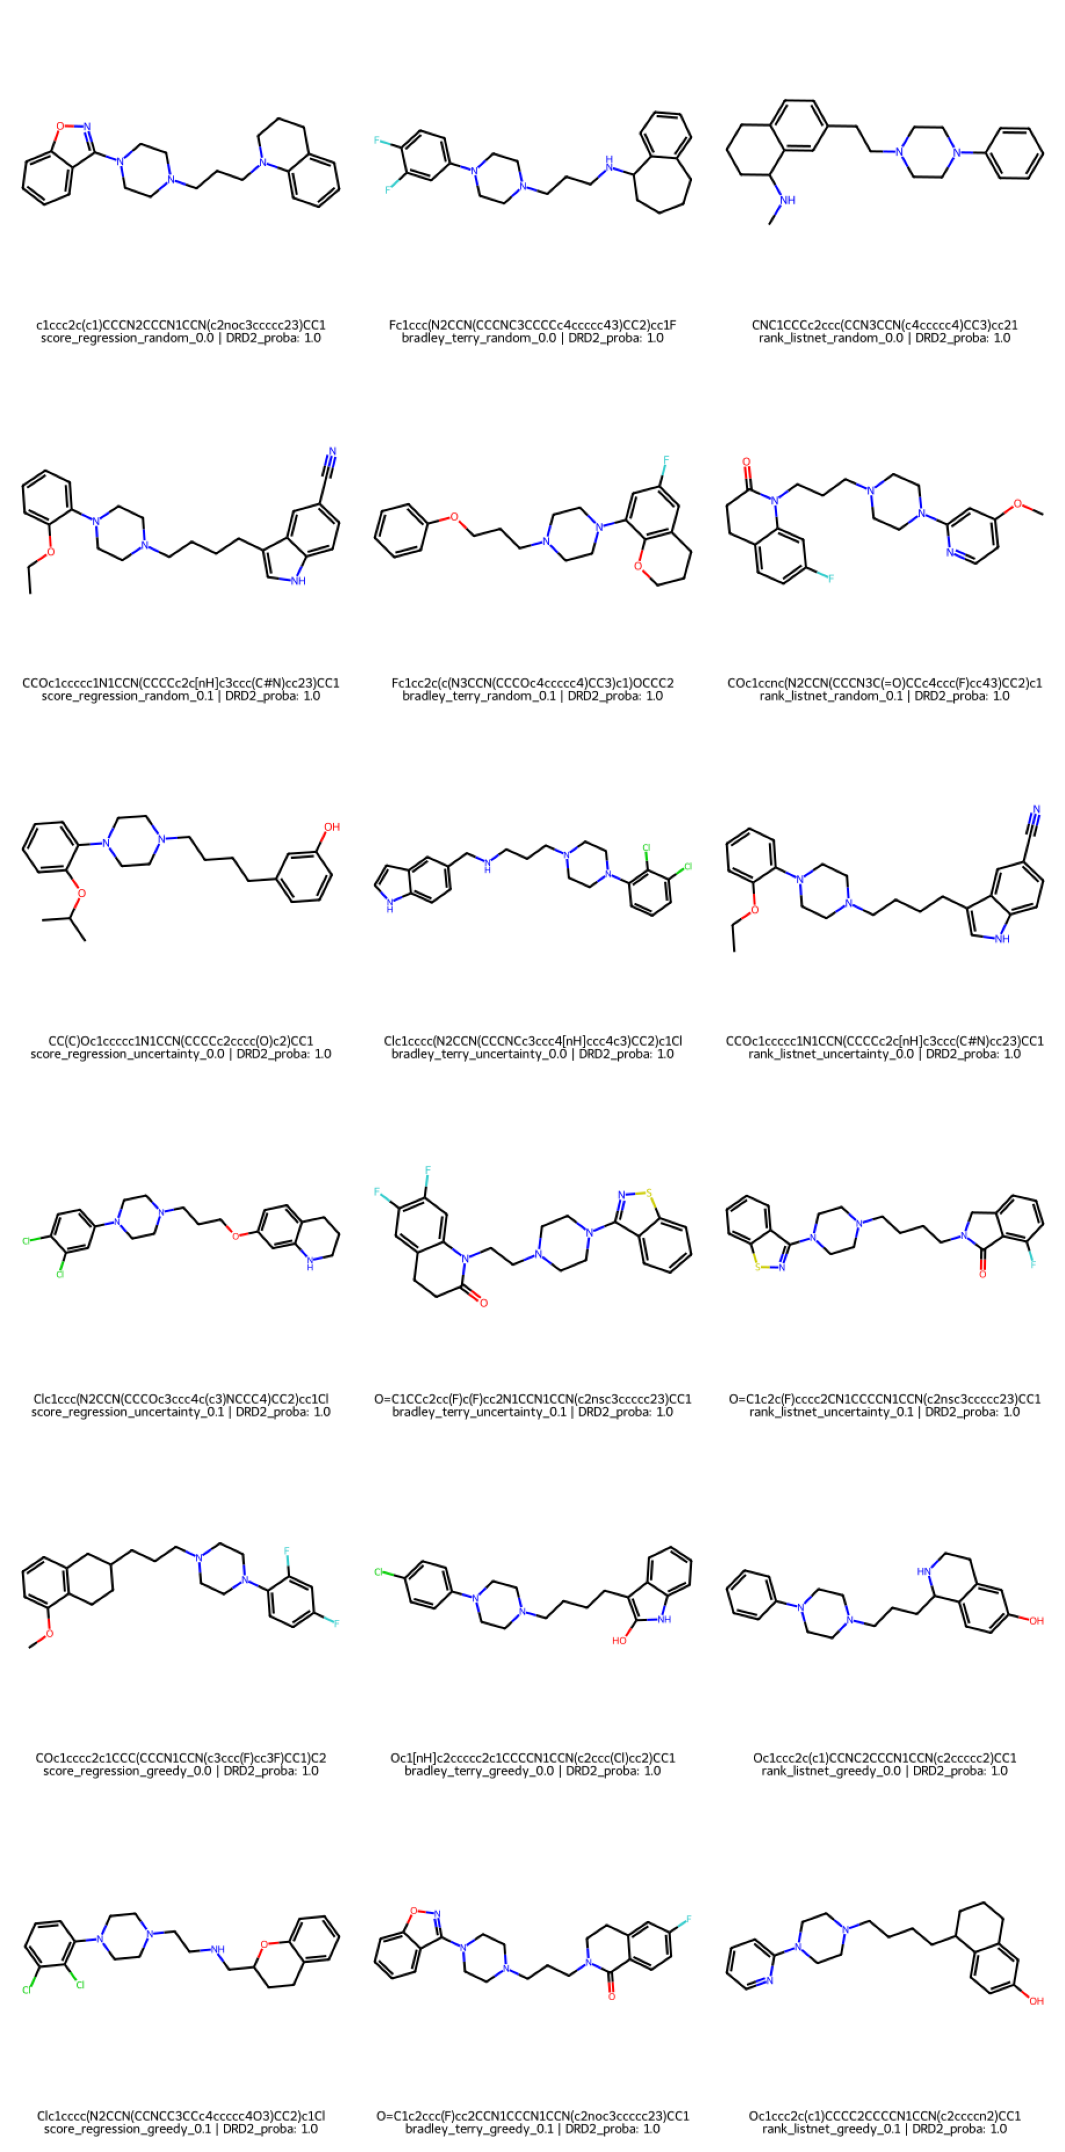

In [45]:
import os
import shutil
import matplotlib.pyplot as plt
from rdkit import Chem
from rdkit.Chem import Draw

# Assuming `filtered_models` and `model_names` are defined elsewhere in your code

def draw_one_molecule(smile, legend_name):
    mol = Chem.MolFromSmiles(smile)
    img = Draw.MolToImage(mol, legend=legend_name, size=(300, 300))
    return img

fig, ax = plt.subplots(6, 3, figsize=(15, 30))
ax = ax.flatten()
index = 0
    
for acquisition in ["random", "uncertainty", "greedy"]:
    for sigma_noise in [0.0, 0.1]:
        # Create the figure and axes once for each acquisition and noise combination
        for model_name in model_names:
            REINVENT_round = 4
            REINVENT_round_name = f"REINVENT_round_{REINVENT_round}"
            smiles_list = filtered_models[model_name][f"acq_{acquisition}_noise_{sigma_noise}"]["smiles_list"][REINVENT_round_name]
            drd2_probas = filtered_models[model_name][f"acq_{acquisition}_noise_{sigma_noise}"]["drd2_proba"][REINVENT_round_name]
            sorted_indices = sorted(range(len(drd2_probas)), key=lambda i: drd2_probas[i], reverse=True)
            max_index = sorted_indices[0]
            smile = smiles_list[max_index]
            props = {prop: filtered_models[model_name][f"acq_{acquisition}_noise_{sigma_noise}"][prop][REINVENT_round_name][max_index] for prop in [
                "drd2_proba", "novelty_score", "sa_score", "qed_score", "logP", "mol_weight", "h_donors", "h_acceptors", "tpsa", "rotatable_bonds", "num_rings"]}
            drd2_proba = props["drd2_proba"]
            legend_name = f"{smile}\n{model_name}_{acquisition}_{sigma_noise} | DRD2_proba: {round(drd2_proba, 4)}"
            img = draw_one_molecule(smile, legend_name)
            ax[index].imshow(img)
            ax[index].axis('off')
            index += 1
     
plt.tight_layout()
plt.show()


In [49]:
### Draw the smiles using RDKit for filtered molecules
from rdkit.Chem import Draw

def draw_one_molecules(smile):
    mol = Chem.MolFromSmiles(smile)
    img = Draw.MolToImage(mol, legend=smile, size=(300, 300))
    return img

run_this_cell = False

if run_this_cell:
    for i, model_name in enumerate(model_names):
        if os.path.exists(f"smiles_figure_{model_name}"):
            shutil.rmtree(f"smiles_figure_{model_name}")
        os.mkdir(f"smiles_figure_{model_name}")
        for acquisition in ["random", "uncertainty", "greedy"]:
            for sigma_noise in [0.0, 0.1]:
                os.makedirs(f"smiles_figure_{model_name}_n_steps_100/acq_{acquisition}_noise_{sigma_noise}", exist_ok=True)
                for REINVENT_round in [4]:
                    os.makedirs(f"smiles_figure_{model_name}_n_steps_100/acq_{acquisition}_noise_{sigma_noise}/REINVENT_round_{REINVENT_round}", exist_ok=True)
                    
                    REINVENT_round_name = f"REINVENT_round_{REINVENT_round}"
                    smiles_list = filtered_models[model_name][f"acq_{acquisition}_noise_{sigma_noise}"]["smiles_list"][REINVENT_round_name]
                    for i, smile in enumerate(smiles_list):
                        img = draw_one_molecules(smile)
                        img.save(f"smiles_figure_{model_name}_n_steps_100/acq_{acquisition}_noise_{sigma_noise}/REINVENT_round_{REINVENT_round}/molecule_{i+1}.png")



### Benchmark 1: Model performance on predicting DRD2 activity using ROC-AUC score
### 

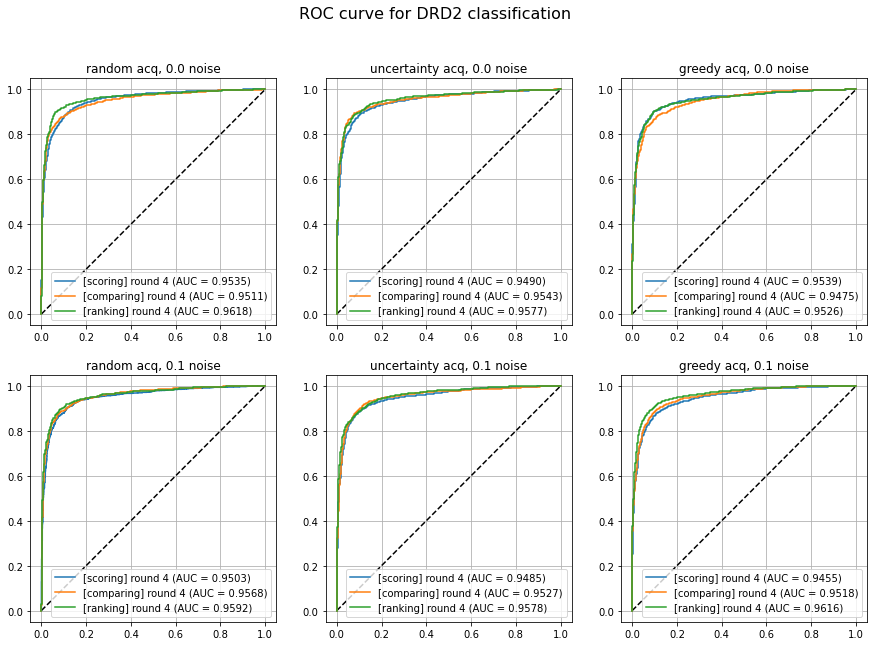

In [ ]:
# Plotting 2 x 3 grid
fig, ax = plt.subplots(2, 3, figsize=(15, 10))

# flatten ax
ax = ax.flatten()

# subplot title
fig.suptitle("ROC curve for DRD2 classification", fontsize=16)

index = 0
for sigma_noise in [0.0, 0.1]:
    for acquisition in ["random", "uncertainty", "greedy"]:
        for REINVENT_round in [4]:
            REINVENT_round_name = f"REINVENT_round_{REINVENT_round}"
            
            fpr_scoring = models["score_regression"][f"acq_{acquisition}_noise_{sigma_noise}"]["metrics"][REINVENT_round_name]['fpr']
            tpr_scoring = models["score_regression"][f"acq_{acquisition}_noise_{sigma_noise}"]["metrics"][REINVENT_round_name]['tpr']
            roc_auc_scoring = models["score_regression"][f"acq_{acquisition}_noise_{sigma_noise}"]["metrics"][REINVENT_round_name]['roc_auc']

            fpr_comparing = models["bradley_terry"][f"acq_{acquisition}_noise_{sigma_noise}"]["metrics"][REINVENT_round_name]['fpr']
            tpr_comparing = models["bradley_terry"][f"acq_{acquisition}_noise_{sigma_noise}"]["metrics"][REINVENT_round_name]['tpr']
            roc_auc_comparing = models["bradley_terry"][f"acq_{acquisition}_noise_{sigma_noise}"]["metrics"][REINVENT_round_name]['roc_auc']

            fpr_ranking = models["rank_listnet"][f"acq_{acquisition}_noise_{sigma_noise}"]["metrics"][REINVENT_round_name]['fpr']
            tpr_ranking = models["rank_listnet"][f"acq_{acquisition}_noise_{sigma_noise}"]["metrics"][REINVENT_round_name]['tpr']
            roc_auc_ranking = models["rank_listnet"][f"acq_{acquisition}_noise_{sigma_noise}"]["metrics"][REINVENT_round_name]['roc_auc']

            # Draw a diagonal line
            ax[index].plot([0, 1], [0, 1], 'k--')
            ax[index].plot(fpr_scoring, tpr_scoring, label=f"[scoring] round {REINVENT_round} (AUC = {roc_auc_scoring:.4f})")
            ax[index].plot(fpr_comparing, tpr_comparing, label=f"[comparing] round {REINVENT_round} (AUC = {roc_auc_comparing:.4f})")
            ax[index].plot(fpr_ranking, tpr_ranking, label=f"[ranking] round {REINVENT_round} (AUC = {roc_auc_ranking:.4f})")
            
            # turn on grid for each subplot
            ax[index].grid()
            ax[index].set_title(f"{acquisition} acq, {sigma_noise} noise")
            ax[index].legend(loc='lower right')
            
        index += 1


### Benchmark 2: DRD2 activity probability distribution of molecules generated by REINVENT

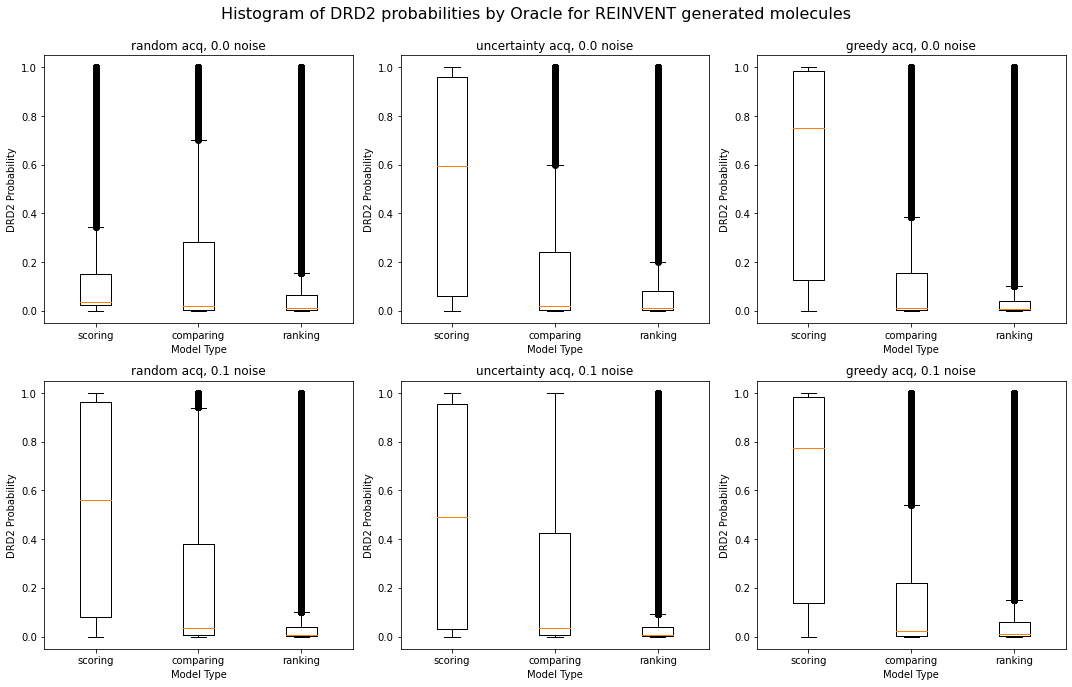

In [ ]:
fig, ax = plt.subplots(2, 3, figsize=(15, 10))

# Flatten ax
ax = ax.flatten()

# Subplot title
fig.suptitle("Histogram of DRD2 probabilities by Oracle for REINVENT generated molecules", fontsize=16)

index = 0
for sigma_noise in [0.0, 0.1]:
    for acquisition in ["random", "uncertainty", "greedy"]:
        for REINVENT_round in [4]:
            REINVENT_round_name = f"REINVENT_round_{REINVENT_round}"
            proba_scoring = filtered_models["score_regression"][f"acq_{acquisition}_noise_{sigma_noise}"]["drd2_proba"][REINVENT_round_name]
            proba_comparing = filtered_models["bradley_terry"][f"acq_{acquisition}_noise_{sigma_noise}"]["drd2_proba"][REINVENT_round_name]
            proba_ranking = filtered_models["rank_listnet"][f"acq_{acquisition}_noise_{sigma_noise}"]["drd2_proba"][REINVENT_round_name]

            max_proba_scoring = max(proba_scoring)
            max_proba_comparing = max(proba_comparing)
            max_proba_ranking = max(proba_ranking)
            # Creating a box plot
            ax[index].boxplot([proba_scoring, proba_comparing, proba_ranking], labels=['scoring', 'comparing', 'ranking'])
            #ax[index].set_ylim(0.65, 1.05)
            ax[index].set_title(f"{acquisition} acq, {sigma_noise} noise")
            ax[index].set_xlabel('Model Type')
            ax[index].set_ylabel('DRD2 Probability')
            
        index += 1

plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

### Plot the molecules from the filtered models

### Benchmark 3: Novelty of molecules generated by REINVENT using Tanimoto similarity

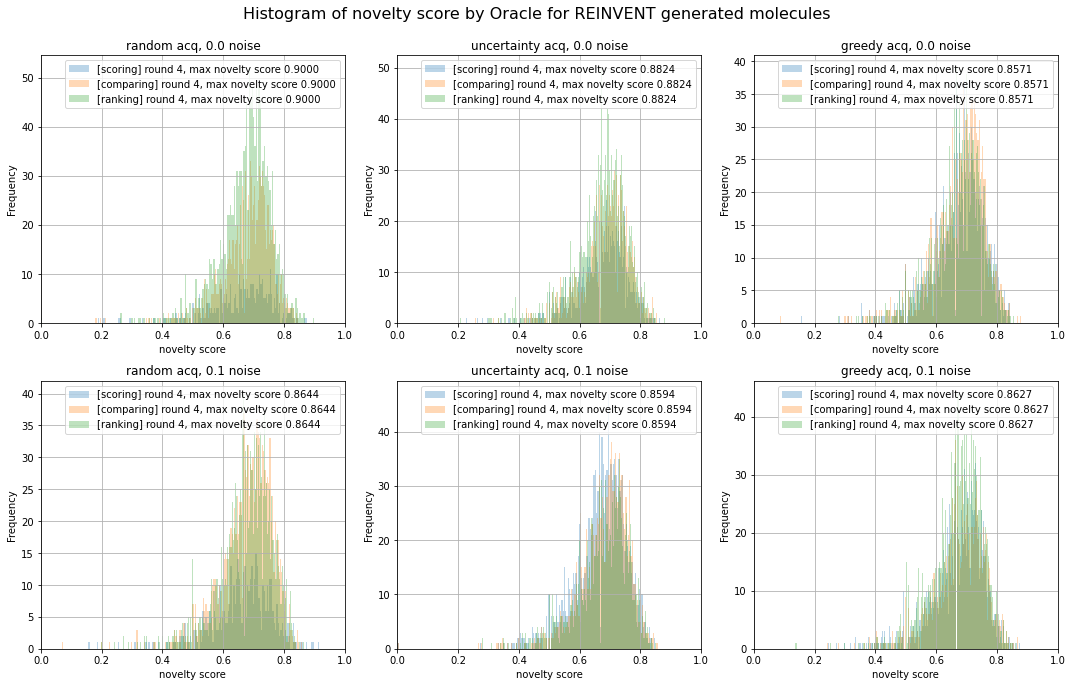

In [ ]:
fig, ax = plt.subplots(2, 3, figsize=(15, 10))

# Flatten ax
ax = ax.flatten()

# Subplot title
fig.suptitle("Histogram of novelty score for REINVENT generated molecules", fontsize=16)

index = 0
for sigma_noise in [0.0, 0.1]:
    for acquisition in ["random", "uncertainty", "greedy"]:
        for REINVENT_round in [4]:
            REINVENT_round_name = f"REINVENT_round_{REINVENT_round}"
            novelty_score_scoring = score_regression_analytics[f"acq_{acquisition}_noise_{sigma_noise}"]["novelty_score"][REINVENT_round_name]
            novelty_score_comparing = bradley_terry_analytics[f"acq_{acquisition}_noise_{sigma_noise}"]["novelty_score"][REINVENT_round_name]
            novelty_score_ranking = rank_listnet_analytics[f"acq_{acquisition}_noise_{sigma_noise}"]["novelty_score"][REINVENT_round_name]

            max_novelty_score = max(novelty_score_scoring)
            max_novelty_score = max(novelty_score_comparing)
            max_novelty_score = max(novelty_score_ranking)

            # Plot histograms
            ax[index].hist(novelty_score_scoring, bins=200, alpha=0.3, label=f"[scoring] round {REINVENT_round}, max novelty score {max_novelty_score:.4f}")
            ax[index].hist(novelty_score_comparing, bins=200, alpha=0.3, label=f"[comparing] round {REINVENT_round}, max novelty score {max_novelty_score:.4f}")
            ax[index].hist(novelty_score_ranking, bins=200, alpha=0.3, label=f"[ranking] round {REINVENT_round}, max novelty score {max_novelty_score:.4f}")
            
            # Turn on grid for each subplot
            ax[index].grid()
            ax[index].set_xlim(0, 1.0)
            ax[index].set_title(f"{acquisition} acq, {sigma_noise} noise")
            ax[index].legend(loc='upper right')
            ax[index].set_xlabel('novelty score')
            ax[index].set_ylabel('Frequency')
            
        index += 1

plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

### Benchmark 4: Synthetic Accessibility (SA) score of molecules generated by REINVENT

SA score is calculated using RDKit implementation of the synthetic accessibility score as described in Ertl et al. (2009). The SA score is a measure of the complexity of a molecule, with higher scores indicating higher complexity. 

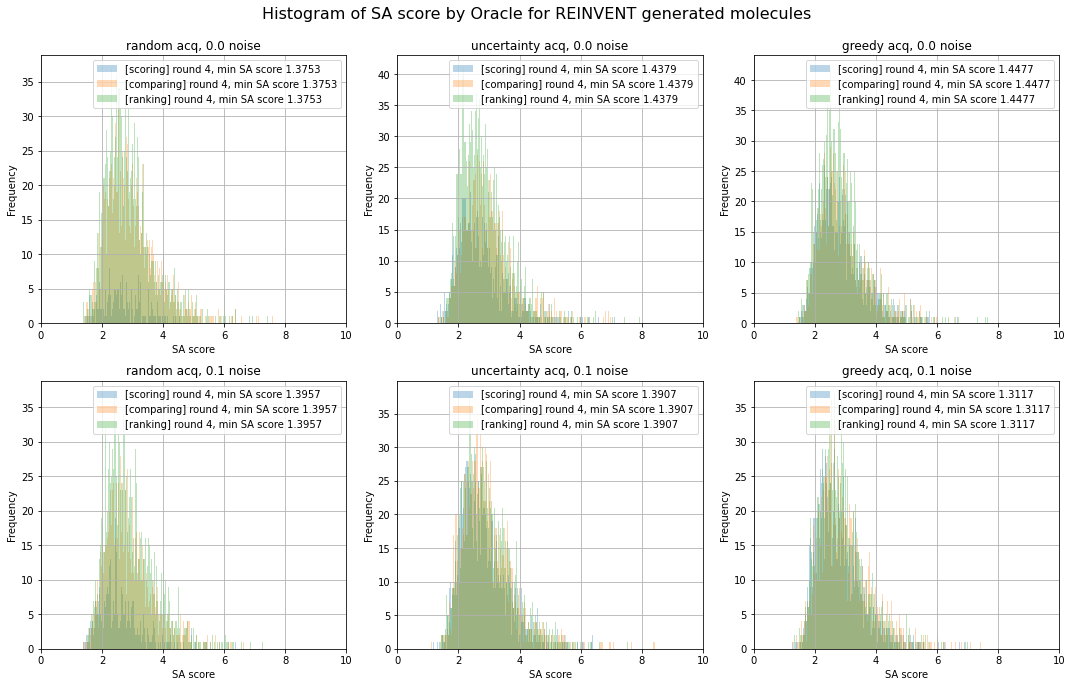

In [ ]:
fig, ax = plt.subplots(2, 3, figsize=(15, 10))

# Flatten ax
ax = ax.flatten()

# Subplot title
fig.suptitle("Histogram of SA score for REINVENT generated molecules", fontsize=16)

index = 0
for sigma_noise in [0.0, 0.1]:
    for acquisition in ["random", "uncertainty", "greedy"]:
        for REINVENT_round in [4]:
            REINVENT_round_name = f"REINVENT_round_{REINVENT_round}"
            sa_score_scoring = score_regression_analytics[f"acq_{acquisition}_noise_{sigma_noise}"]["sa_score"][REINVENT_round_name]
            sa_score_comparing = bradley_terry_analytics[f"acq_{acquisition}_noise_{sigma_noise}"]["sa_score"][REINVENT_round_name]
            sa_score_ranking = rank_listnet_analytics[f"acq_{acquisition}_noise_{sigma_noise}"]["sa_score"][REINVENT_round_name]

            sa_min_score = min(sa_score_scoring)
            sa_min_score = min(sa_score_comparing)
            sa_min_score = min(sa_score_ranking)

            # Plot histograms
            ax[index].hist(sa_score_scoring, bins=200, alpha=0.3, label=f"[scoring] round {REINVENT_round}, min SA score {sa_min_score:.4f}")
            ax[index].hist(sa_score_comparing, bins=200, alpha=0.3, label=f"[comparing] round {REINVENT_round}, min SA score {sa_min_score:.4f}")
            ax[index].hist(sa_score_ranking, bins=200, alpha=0.3, label=f"[ranking] round {REINVENT_round}, min SA score {sa_min_score:.4f}")

            # Turn on grid for each subplot
            ax[index].grid()
            ax[index].set_xlim(0, 10) # SA score range from 0 to 10
            ax[index].set_title(f"{acquisition} acq, {sigma_noise} noise")
            ax[index].legend(loc='upper right')
            ax[index].set_xlabel('SA score')
            ax[index].set_ylabel('Frequency')
            
        index += 1

plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

### Benchmark 5: Pharmacokinetic (PK) parameter logP of molecules generated by REINVENT

PK parameters play a crucial role in understanding how a drug interacts with the body during drug development. These parameters provide insights into various aspects (ADME):

- Absorption: How the drug is absorbed after administration.
- Distribution: How the drug spreads across different bodily compartments or tissues.
- Metabolism: How the body processes or degrades the drug.
- Excretion: How the body eliminates or gets rid of the drug.


The logP parameter, or the partition coefficient, is a crucial molecular descriptor in medicinal chemistry and drug design. It quantifies the lipophilicity of chemical compounds and influences their pharmacokinetic properties

| LogP | Value Range | Characteristics | 
| --- | --- | --- |
| \< 1 | Too hydrophilic | Poor absorption, rapid excretion |
| 1 - 3 | Balanced hydrophilic and hydrophobic | Good absorption and bioavailability |
| 3 - 5 | Moderately hydrophobic | Potential absorption issues, consider formulation |
| \> 5 | Too hydrophobic | Poor solubility, potential toxicity, poor absorption |



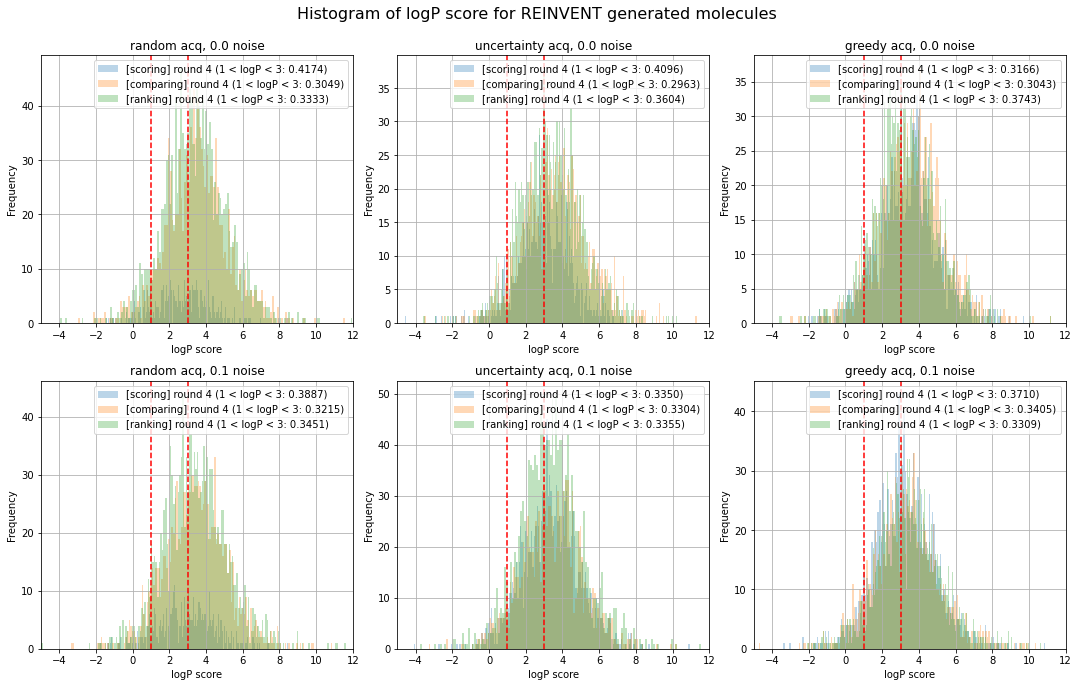

In [ ]:
fig, ax = plt.subplots(2, 3, figsize=(15, 10))

# Flatten ax
ax = ax.flatten()

# Subplot title
fig.suptitle("Histogram of logP score for REINVENT generated molecules", fontsize=16)

index = 0
for sigma_noise in [0.0, 0.1]:
    for acquisition in ["random", "uncertainty", "greedy"]:
        for REINVENT_round in [4]:
            REINVENT_round_name = f"REINVENT_round_{REINVENT_round}"
            logP_score_scoring = score_regression_analytics[f"acq_{acquisition}_noise_{sigma_noise}"]["logP_score"][REINVENT_round_name]
            logP_score_comparing = bradley_terry_analytics[f"acq_{acquisition}_noise_{sigma_noise}"]["logP_score"][REINVENT_round_name]
            logP_score_ranking = rank_listnet_analytics[f"acq_{acquisition}_noise_{sigma_noise}"]["logP_score"][REINVENT_round_name]

            # calculate percentage of molecules with logP score > 1 and < 3
            logP_score_scoring_1_3 = [x for x in logP_score_scoring if 1 < x < 3]
            logP_score_comparing_1_3 = [x for x in logP_score_comparing if 1 < x < 3]
            logP_score_ranking_1_3 = [x for x in logP_score_ranking if 1 < x < 3]

            logP_score_scoring_1_3_percentage = len(logP_score_scoring_1_3) / len(logP_score_scoring)
            logP_score_comparing_1_3_percentage = len(logP_score_comparing_1_3) / len(logP_score_comparing)
            logP_score_ranking_1_3_percentage = len(logP_score_ranking_1_3) / len(logP_score_ranking)

            # Plot histograms
            ax[index].hist(logP_score_scoring, bins=200, alpha=0.3, label=f"[scoring] round {REINVENT_round} (1 < logP < 3: {logP_score_scoring_1_3_percentage:.4f})")
            ax[index].hist(logP_score_comparing, bins=200, alpha=0.3, label=f"[comparing] round {REINVENT_round} (1 < logP < 3: {logP_score_comparing_1_3_percentage:.4f})")
            ax[index].hist(logP_score_ranking, bins=200, alpha=0.3, label=f"[ranking] round {REINVENT_round} (1 < logP < 3: {logP_score_ranking_1_3_percentage:.4f})")

            # Draw two red vertical lines at 1 and 3
            ax[index].axvline(x=1, color='r', linestyle='--')
            ax[index].axvline(x=3, color='r', linestyle='--')

            # Turn on grid for each subplot
            ax[index].grid()
            ax[index].set_xlim(-5, 12) # logP score range from -5 to 6
            ax[index].set_title(f"{acquisition} acq, {sigma_noise} noise")
            ax[index].legend(loc='upper right')
            ax[index].set_xlabel('logP score')
            ax[index].set_ylabel('Frequency')
            
        index += 1

plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()